# ARMA
##### Sean Wade

In [45]:
from __future__ import division, print_function
import numpy as np
from numpy.random import multivariate_normal
import numpy.linalg as la
import pandas as pd
from scipy.stats import norm
import scipy.optimize as op

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from IPython.core.display import HTML
import urllib2
# HTML(urllib2.urlopen('http://seanwade.com/jupyter_2.css').read())

## Load in Data

In [8]:
time_series_a = np.loadtxt('ARMA-Kalman-data/time_series_a.txt')
time_series_b = np.loadtxt('ARMA-Kalman-data/time_series_b.txt')
time_series_c = np.loadtxt('ARMA-Kalman-data/time_series_c.txt')

## Train with Kalman Filter

In [10]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector. 
        """    
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        return
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman 
        system.
        
        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.
        
        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        """
        m, n = self.H.shape[0], len(x0)

        states = np.zeros((N,n))
        states[0] = x0
        
        obs = np.zeros((N, m))
        obs[0] = x0[:m]
        
        for i in xrange(N-1):
            eps = np.random.multivariate_normal(np.zeros(Q.shape[0]), Q)
            delt = np.random.multivariate_normal(np.zeros(R.shape[0]), R)
            
            states[i+1] = self.F.dot(states[i]) + self.u + eps
            obs[i+1] = self.H.dot(states[i]) + delt
            
        return states, obs

    def estimate(self,x,P,z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.
        
        Parameters
        ----------
        x : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).
        
        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        N = len(z)
        z = z.reshape((1,N))
        n, m, N = len(x), z.shape[0], z.shape[1]        
        
        out = np.zeros((n,N))
        out[:,0] = np.copy(x)
        
        x_ = []
        x_hats = []
        P_list = []
        
        for i in xrange(N):
            xk1 = self.F.dot(x) + self.u
            Pk1 = self.F.dot(P).dot(self.F.T) + self.Q
            y = z[:,i] - self.H.dot(xk1)
            S = self.H.dot(Pk1).dot(self.H.T) + self.R
            K = Pk1.dot(self.H.T.reshape((n,m))).dot(la.inv(S))
            x = xk1 + K.dot(y)
            
            #out[0,i] = x
            x_.append(x)
            P = (np.eye(n) - K.dot(self.H.reshape((m,n)))).dot(Pk1)
            
            x_hats.append(xk1)
            P_list.append(Pk1)
        
        return out, x_hats, P_list
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
        The next k predicted states.
        """
        n = len(x)
        out = np.zeros((k,n))
        out[0] = x
        
        for i in xrange(k-1):
            out[i+1] = self.F.dot(out[i]) + self.u
            
        return out
    
    def rewind(self,x,k):
        """
        Predict the k states preceding the current state estimate x.
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of preceding states to predict.
        Returns
        -------
        out : ndarray of shape (n,k)
        The k preceding predicted states.
        """
        n = len(x)
        out = np.zeros((k,n))
        out[0] = x
                
        for i in xrange(k-1):
            out[i+1] = np.linalg.inv(self.F).dot(out[i] - self.u)
            
        return out

## Problem 1

In [22]:
def arma_likelihood(time_series, phis=np.array([]), thetas=np.array([]), mu=0, sigma=1):
    """
    Return the log-likelihood of the ARMA model parameters, given the time
    series.
    
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    
    Returns
    -------
    log_likelihood : float
        The log-likelihood of the model
    """
    n, p, q = time_series.shape[0], len(phis), len(thetas)
    z = time_series - mu
    r = max(p, q+1)
    
    F = np.diag(np.ones(r-1), k=-1)
    if p < r:
        F[0][:p] = phis
    else:
        F[0,:] = phis[:r]
    
    H = np.zeros(r)
    H[0] = 1
    
    if q+1 < r:
        H[1:q+1] = thetas
    else:
        H[1:] = thetas[:r-1]
    
    Q = np.zeros((r,r))
    Q[0,0] = sigma**2
    
    
    m, n = 1, len(H)
    R = np.zeros((m,m))
    u = np.zeros(n)
    
    k = KalmanFilter(F, Q, H, R, u)
        
    x0 = np.zeros(r)
    P = np.linalg.inv(np.eye(r**2) - np.kron(F, F)).dot(Q.flatten())
    P = P.reshape((r,r))
    
    est, Xs, Ps = k.estimate(x0, P, z)
    draws = []
    for i in xrange(len(Xs)):
        mean = H.dot(Xs[i]) + mu
        var = H.dot(Ps[i]).dot(H.T)
        draws.append(norm.pdf(time_series[i], loc=mean, scale=np.sqrt(var)))

    return np.sum(np.log(draws))

In [23]:
arma_likelihood(time_series_a, phis=np.array([0.9]), mu=17., sigma=0.4)

-77.603544965522772

## Problem 2

In [26]:
def arma_fit(time_series):
    """
    Return the ARMA model that minimizes AICc for the given time series,
    subject to p,q <= 3.
    
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
    
    Returns
    -------
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    """
    n = len(time_series)
    params = []
    AICs = []
    for p in range(1,4):
        for q in range(1,4):
            k = p + q + 2

            def f(x): # x contains the phis, thetas, mu, and sigma
                return -1*arma_likelihood(time_series, phis=x[:p], thetas=x[p:p+q], mu=x[-2],sigma=x[-1])

            # create initial point
            x0 = np.zeros(p+q+2)
            x0[-2] = time_series.mean()
            x0[-1] = time_series.std()
            sol = op.fmin(f,x0,maxiter=10000, maxfun=10000) 
            l = np.exp(-1*f(sol))
            AIC = 2*k * (1 + (k+1)/(n-k)) - 2*l
            params.append((p, q, sol[:p], sol[p:p+q], sol[-2], sol[-1]))
            AICs.append(AIC)
    opt_idx = np.argmin(AICs)
    return params[opt_idx]

## Problem 3

In [32]:
# find the optimum for the series
opt_list = []
for time_series in [time_series_a, time_series_b, time_series_c]:
    optimum = arma_fit(time_series)
    opt_list.append(optimum)

/home/seanwade/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in sqrt


Optimization terminated successfully.
         Current function value: 50.745092
         Iterations: 202
         Function evaluations: 340
Optimization terminated successfully.
         Current function value: 50.045019
         Iterations: 561
         Function evaluations: 898
Optimization terminated successfully.
         Current function value: 49.181500
         Iterations: 933
         Function evaluations: 1444
Optimization terminated successfully.
         Current function value: 49.784073
         Iterations: 452
         Function evaluations: 726
Optimization terminated successfully.
         Current function value: 50.608759
         Iterations: 556
         Function evaluations: 869
Optimization terminated successfully.
         Current function value: 49.174555
         Iterations: 903
         Function evaluations: 1354
Optimization terminated successfully.
         Current function value: 52.889214
         Iterations: 408
         Function evaluations: 648
Optimizatio

In [35]:
for opt, name in zip(opt_list, ['A', 'B', 'C']):
    print("Optimal Solution for Time Series %s:" % name)
    print("-"*40)
    print("p: %d" % opt[0])
    print("q: %d" % opt[1])
    print("Phis: %s" % opt[2])
    print("Thetas: %s" % opt[3])
    print("Mu: %f" % opt[4])
    print("Sigma: %f\n" % opt[5])

Optimal Solution for Time Series A:
----------------------------------------
p: 1
q: 1
Phis: [ 0.90867024]
Thetas: [-0.57585945]
Mu: 17.065262
Sigma: 0.312531

Optimal Solution for Time Series B:
----------------------------------------
p: 1
q: 1
Phis: [ 0.0391853]
Thetas: [ 0.04673145]
Mu: -0.279236
Sigma: 7.221581

Optimal Solution for Time Series C:
----------------------------------------
p: 1
q: 1
Phis: [ 0.72176236]
Thetas: [ 0.76386018]
Mu: 50.054805
Sigma: 16.001731



## Problem 4

In [36]:
def arma_forecast(time_series, phis=np.array([]), thetas=np.array([]), mu=0,
sigma=1, future_periods=20):
    """
    Return forecasts for a time series modeled with the given ARMA model.
    
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    future_periods : int
        The number of future periods to return
    
    Returns
    -------
    e_vals : ndarray of shape (future_periods,)
        The expected values of z for times n+1, ..., n+future_periods
    sigs : ndarray of shape (future_periods,)
        The standard deviations of z for times n+1, ..., n+future_periods
    """
    n, p, q = time_series.shape[0], len(phis), len(thetas)
    z = time_series - mu
    r = max(p, q+1)
    
    
    F = np.diag(np.ones(r-1), k=-1)
    if p < r:
        F[0][:p] = phis
    else:
        F[0,:] = phis[:r]
    
    H = np.zeros(r)
    H[0] = 1
    
    if q+1 < r:
        H[1:q+1] = thetas
    else:
        H[1:] = thetas[:r-1]
    
    Q = np.zeros((r,r))
    Q[0,0] = sigma**2
    
    
    m, n = 1, len(H)
    R = np.zeros((m,m))
    u = np.zeros(n)
    
    k = KalmanFilter(F,Q,H,R,u)
     
    x0 = np.zeros(r)
    P = np.linalg.inv(np.eye(r**2) - np.kron(F, F)).dot(Q.flatten())
    P = P.reshape((r,r))
    
    est, Xs, Ps = k.estimate(x0, P, z)
    
    xk = Xs[-1]
    pk = Ps[-1]
    
    x_p = []
    p_p = []
    
    for i in xrange(future_periods):
        xk = F.dot(xk)
        pk = F.dot(pk).dot(F.T) + Q
        x_p.append(xk)
        p_p.append(pk)
    
    e_vals = np.array([H.dot(np.array(xi)) + mu for xi in x_p])
    sigs = np.array([np.sqrt(H.dot(np.array(pi)).dot(H.T)) for pi in p_p])

    return(e_vals, sigs)

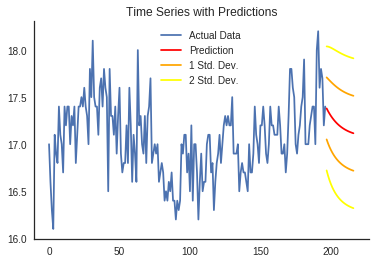

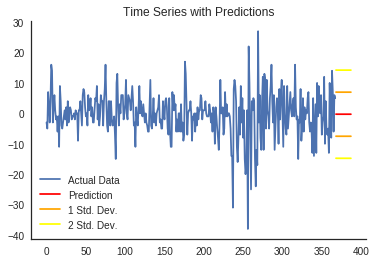

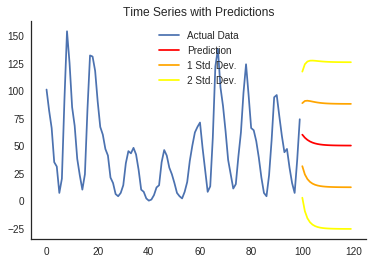

In [49]:
for series, opt in zip([time_series_a, time_series_b, time_series_c], opt_list):

    e_vals, sigs = arma_forecast(series, opt[2], opt[3], opt[4], opt[5], 20)
    n = len(series)
    plt.plot(np.arange(n), series, label='Actual Data')
    plt.plot(np.arange(n, n+20), e_vals, color='red', label='Prediction')
    plt.plot(np.arange(n, n+20), e_vals - sigs, color='orange',label='1 Std. Dev.')
    plt.plot(np.arange(n, n+20), e_vals + sigs, color='orange')
    plt.plot(np.arange(n, n+20), e_vals - 2*sigs, color='yellow', label='2 Std. Dev.')
    plt.plot(np.arange(n, n+20), e_vals + 2*sigs, color='yellow')
    plt.title('Time Series with Predictions')
    plt.legend(loc='best')
    sns.despine()
    plt.show()